# Technical Analysis Of Intel

## Purpose
This phase of the project focuses on conducting an in-depth exploratory data analysis (EDA) of the selected stock. The goal is to extract valuable insights and explore key statistics that will lay the foundation for building a robust stock market forecasting system capable of providing actionable recommendations—Buy, Sell, or Hold.
### 1.0 Load Data and Calculate Key Statistics

## Potential stocks of interest 
    - INTC  
    - AAPL
    - INTC
    - MLTX
    - TSLA
    - HON


In [2]:
# Importing Libraries and Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import mplfinance as mpf
import plotly.graph_objects as go
import yfinance as yf
from scipy.stats import norm
from SimulateDay import add_columns
import datetime
stock_df = pd.read_csv('data/sp500_stocks.csv')

In [10]:

company_df = pd.read_csv('data/sp500_companies.csv')
stock_df = pd.read_csv('data/sp500_stocks.csv')
merged_df = pd.merge(stock_df, company_df[['Symbol', 'Sector']], on='Symbol', how='left')

def _select_stock():
    company_name = input('Enter the name of the company: ')
    return stock_df[stock_df['Symbol'] == company_name]

merged_df.to_csv('data/sp500_stock_sector.csv', index=False)
# stock_df = _select_stock()
# stock_df

In [132]:
stock_df['1_Day_Return'] = (stock_df['Close'] - stock_df['Close'].shift(1)) / stock_df['Close'].shift(1) * 100
stock_df['5_Day_Return'] = (stock_df['Close'] - stock_df['Close'].shift(5)) / stock_df['Close'].shift(5) * 100
stock_df['10_Day_Return'] = (stock_df['Close'] - stock_df['Close'].shift(10)) / stock_df['Close'].shift(10) * 100
stock_df['20_Day_Return'] = (stock_df['Close'] - stock_df['Close'].shift(20)) / stock_df['Close'].shift(20) * 100
stock_df['50_Day_Return'] = (stock_df['Close'] - stock_df['Close'].shift(50)) / stock_df['Close'].shift(50) * 100
stock_df['200_Day_Return'] = (stock_df['Close'] - stock_df['Close'].shift(200)) / stock_df['Close'].shift(200) * 100

stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)
stock_df['Best_Return'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].max(axis=1)
stock_df['Best_Return_Window'] = stock_df['Best_Return_Window'].replace('_Day_Return', '', regex=True)


/var/folders/75/l95mxw1j5w9ddljb82_6_m_40000gn/T/ipykernel_84660/4008321228.py:8: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


In [133]:
# Create lag columns
stock_df['close_lag1'] = stock_df['Close'].shift(1)
stock_df['close_lag2'] = stock_df['Close'].shift(2)
stock_df['close_lag3'] = stock_df['Close'].shift(3)
stock_df['close_lag4'] = stock_df['Close'].shift(5)
stock_df['close_lag5'] = stock_df['Close'].shift(10)

stock_df['volume_lag1'] = stock_df['Volume'].shift(1)
stock_df['volume_lag2'] = stock_df['Volume'].shift(2)
stock_df['volume_lag3'] = stock_df['Volume'].shift(3)
stock_df['volume_lag4'] = stock_df['Volume'].shift(5)
stock_df['volume_lag5'] = stock_df['Volume'].shift(10)

In [134]:
# Create new columns with Moving Averages and Standard Deviations

stock_df['Date'] = pd.to_datetime(stock_df['Date'])

stock_df['MA_10'] = stock_df.groupby('Symbol')['Close'].rolling(window=10).mean().reset_index(level=0, drop=True)
stock_df['MA_20'] = stock_df.groupby('Symbol')['Close'].rolling(window=20).mean().reset_index(level=0, drop=True)
stock_df['MA_50'] = stock_df.groupby('Symbol')['Close'].rolling(window=50).mean().reset_index(level=0, drop=True)
stock_df['MA_200'] = stock_df.groupby('Symbol')['Close'].rolling(window=200).mean().reset_index(level=0, drop=True)
stock_df['std_10'] = stock_df.groupby('Symbol')['Close'].rolling(window=10).std().reset_index(level=0, drop=True)
stock_df['std_20'] = stock_df.groupby('Symbol')['Close'].rolling(window=20).std().reset_index(level=0, drop=True)
stock_df['std_50'] = stock_df.groupby('Symbol')['Close'].rolling(window=50).std().reset_index(level=0, drop=True)
stock_df['std_200'] = stock_df.groupby('Symbol')['Close'].rolling(window=200).std().reset_index(level=0, drop=True)


In [135]:
# Create new columns with Bollinger Bands for each Moving Average

stock_df['upper_band_10'] = stock_df['MA_10'] + (stock_df['std_10'] * 2)
stock_df['lower_band_10'] = stock_df['MA_10'] - (stock_df['std_10'] * 2)

stock_df['upper_band_20'] = stock_df['MA_20'] + (stock_df['std_20'] * 2)
stock_df['lower_band_20'] = stock_df['MA_20'] - (stock_df['std_20'] * 2)

stock_df['upper_band_50'] = stock_df['MA_50'] + (stock_df['std_50'] * 2)
stock_df['lower_band_50'] = stock_df['MA_50'] - (stock_df['std_50'] * 2)


stock_df['upper_band_200'] = stock_df['MA_200'] + (stock_df['std_200'] * 2)
stock_df['lower_band_200'] = stock_df['MA_200'] - (stock_df['std_200'] * 2)

In [136]:
# Create new columns Indicating Golden Cross and Death Cross

stock_df['Golden_Cross_Short'] = np.where((stock_df['MA_10'] > stock_df['MA_20']) & (stock_df['MA_10'].shift(1) <= stock_df['MA_20'].shift(1)), 1, 0)
stock_df['Golden_Cross_Medium'] = np.where((stock_df['MA_20'] > stock_df['MA_50']) & (stock_df['MA_20'].shift(1) <= stock_df['MA_50'].shift(1)), 1, 0)
stock_df['Golden_Cross_Long'] = np.where((stock_df['MA_50'] > stock_df['MA_200']) & (stock_df['MA_50'].shift(1) <= stock_df['MA_200'].shift(1)), 1, 0)

stock_df['Death_Cross_Short'] = np.where((stock_df['MA_10'] < stock_df['MA_20']) & (stock_df['MA_10'].shift(1) >= stock_df['MA_20'].shift(1)), 1, 0)
stock_df['Death_Cross_Medium'] = np.where((stock_df['MA_20'] < stock_df['MA_50']) & (stock_df['MA_20'].shift(1) >= stock_df['MA_50'].shift(1)), 1, 0)
stock_df['Death_Cross_Long'] = np.where((stock_df['MA_50'] < stock_df['MA_200']) & (stock_df['MA_50'].shift(1) >= stock_df['MA_200'].shift(1)), 1, 0)

In [137]:
# Create new columns with Rate of Change and Average Volume

stock_df['ROC'] = ((stock_df['Close'] - stock_df['Close'].shift(1)) / stock_df['Close'].shift(1)) * 100

stock_df['AVG_Volume_10'] = stock_df.groupby('Symbol')['Volume'].rolling(window=10).mean().reset_index(level=0, drop=True)
stock_df['AVG_Volume_20'] = stock_df.groupby('Symbol')['Volume'].rolling(window=20).mean().reset_index(level=0, drop=True)
stock_df['AVG_Volume_50'] = stock_df.groupby('Symbol')['Volume'].rolling(window=50).mean().reset_index(level=0, drop=True)
stock_df['AVG_Volume_200'] = stock_df.groupby('Symbol')['Volume'].rolling(window=200).mean().reset_index(level=0, drop=True)

In [138]:
# Create new columns signaling candlestick patterns 

def is_doji(row):
    return abs(row['Close'] - row['Open']) <= (row['High'] - row['Low']) * 0.1
def is_bullish_engulfing(current_row, previous_row):
    # Example logic for identifying a bullish engulfing pattern
    if previous_row['Close'] < previous_row['Open'] and current_row['Close'] > current_row['Open'] and current_row['Close'] > previous_row['Open'] and current_row['Open'] < previous_row['Close']:
        return True
    return False

def is_bearish_engulfing(current_row, previous_row):
    # Example logic for identifying a bearish engulfing pattern
    if previous_row['Close'] > previous_row['Open'] and current_row['Close'] < current_row['Open'] and current_row['Close'] < previous_row['Open'] and current_row['Open'] > previous_row['Close']:
        return True
    return False

# Doji Candlestick Pattern, identified by a small body and long wicks
stock_df['Doji'] = stock_df.apply(is_doji, axis=1)

# Bullish and Bearish Engulfing Candlestick Patterns, identified by a large body that engulfs the previous candle
stock_df['Bullish_Engulfing'] = stock_df.apply(lambda row: is_bullish_engulfing(row, stock_df.shift(1).loc[row.name]), axis=1)
stock_df['Bearish_Engulfing'] = stock_df.apply(lambda row: is_bearish_engulfing(row, stock_df.shift(1).loc[row.name]), axis=1)

In [139]:
# Create new columns for MACD, Signal Line and MACD Histogram

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    # Calculate the short-term EMA
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    
    # Calculate the long-term EMA
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    
    # Calculate the MACD line
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    
    # Calculate the Signal line
    df['Signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    
    # Calculate the MACD histogram
    df['MACD_Hist'] = df['MACD'] - df['Signal']
    
    return df

stock_df = calculate_macd(stock_df)

In [140]:
# Create new columns for Average True Range (ATR) and True Range (TR)

stock_df['Previous_Close'] = stock_df['Close'].shift(1)

# True Range, Shows the volatility of the stock
stock_df['TR'] = stock_df.apply(
    lambda row: max(
        row['High'] - row['Low'],  # High - Low
        abs(row['High'] - row['Previous_Close']),  # |High - Previous Close|
        abs(row['Low'] - row['Previous_Close'])  # |Low - Previous Close|
    ), axis=1
)

# Average True Range, Shows the average volatility of the stock
stock_df['ATR'] = stock_df['TR'].rolling(window=10).mean()

In [141]:
# Create new columns for Relative Strength Index (RSI)

def calculate_rsi(df, window=10):
    # Calculate daily price changes
    delta = df['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and average loss
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calculate the Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Add RSI column to the DataFrame
stock_df['RSI_10_Day'] = calculate_rsi(stock_df)

In [142]:
# Create new columns for 10 Day Rate of Change (ROC)
stock_df['10_Day_ROC'] = ((stock_df['Close'] - stock_df['Close'].shift(10)) / stock_df['Close'].shift(10)) * 100

In [143]:
# Create new columns for 10,20,50 day resistance and support levels
stock_df['Resistance_10_Day'] = stock_df['Close'].rolling(window=10).max()
stock_df['Support_10_Day'] = stock_df['Close'].rolling(window=10).min()
stock_df['Resistance_20_Day'] = stock_df['Close'].rolling(window=20).max()
stock_df['Support_20_Day'] = stock_df['Close'].rolling(window=20).min()
stock_df['Resistance_50_Day'] = stock_df['Close'].rolling(window=50).max()
stock_df['Support_50_Day'] = stock_df['Close'].rolling(window=50).min()

In [144]:
# Create new columns for 10,20,50 day Volume Indicators
stock_df['Volume_MA_10'] = stock_df['Volume'].rolling(window=10).mean()
stock_df['Volume_MA_20'] = stock_df['Volume'].rolling(window=20).mean()
stock_df['Volume_MA_50'] = stock_df['Volume'].rolling(window=50).mean()

In [145]:
def create_OBV(df):
    df['OBV'] = 0
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i - 1]:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1] + df['Volume'].iloc[i]
        elif df['Close'].iloc[i] < df['Close'].iloc[i - 1]:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1] - df['Volume'].iloc[i]
        else:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1]
    return df

stock_df = create_OBV(stock_df)

In [146]:
# Use a smoothed version of 'Close' to detect peaks and troughs
stock_df['Smoothed_Close'] = stock_df['Close'].rolling(window=20).mean()

# Find local minima (buy points) and local maxima (sell points)
# Local minima (buy points)
stock_df['Buy_Signal'] = (stock_df['Smoothed_Close'].shift(1) > stock_df['Smoothed_Close']) & (stock_df['Smoothed_Close'].shift(-1) > stock_df['Smoothed_Close'])

# Local maxima (sell points)
stock_df['Sell_Signal'] = (stock_df['Smoothed_Close'].shift(1) < stock_df['Smoothed_Close']) & (stock_df['Smoothed_Close'].shift(-1) < stock_df['Smoothed_Close'])

# Initialize 'Optimal_Action' column with 'Hold'
stock_df['Optimal_Action'] = 'Hold'

# Assign 'Buy' where Buy_Signal is True
stock_df.loc[stock_df['Buy_Signal'], 'Optimal_Action'] = 'Buy'

# Assign 'Sell' where Sell_Signal is True
stock_df.loc[stock_df['Sell_Signal'], 'Optimal_Action'] = 'Sell'

# Clean up: drop the temporary signals if needed
stock_df.drop(['Buy_Signal', 'Sell_Signal', 'Smoothed_Close'], axis=1, inplace=True)


In [147]:
def calculate_implied_volatility(option_price, stock_price, strike_price, time_to_expiry, risk_free_rate, sigma, option_type='call'):
    # Black-Scholes formula components
    d1 = (np.log(stock_price / strike_price) + (risk_free_rate + 0.5 * sigma ** 2) * time_to_expiry) / (sigma * np.sqrt(time_to_expiry))
    d2 = d1 - sigma * np.sqrt(time_to_expiry)
    
    if option_type == 'call':
        option_price_calc = stock_price * norm.cdf(d1) - strike_price * np.exp(-risk_free_rate * time_to_expiry) * norm.cdf(d2)
    else:
        option_price_calc = strike_price * np.exp(-risk_free_rate * time_to_expiry) * norm.cdf(-d2) - stock_price * norm.cdf(-d1)
    
    return option_price_calc

# Example: Fetch options data for a stock
ticker = 'INTC'
stock = yf.Ticker(ticker)
options = stock.option_chain('2024-10-18')

# Define a sigma value (e.g., 0.2 for 20% volatility)
sigma = 0.2

# Calculate implied volatility and delta for each option
for option in options.calls.itertuples():
    time_to_expiry = (pd.Timestamp('2024-12-20') - pd.Timestamp.today()).days / 365
    implied_volatility = calculate_implied_volatility(option.lastPrice, stock.history(period='1d')['Close'].iloc[-1], option.strike, time_to_expiry, 0.01, sigma)
    delta = norm.cdf((np.log(stock.history(period='1d')['Close'].iloc[-1] / option.strike) + (0.01 + 0.5 * implied_volatility ** 2) * time_to_expiry) / (implied_volatility * np.sqrt(time_to_expiry)))
    print(f"Strike: {option.strike}, Implied Volatility: {implied_volatility}, Delta: {delta}")

Strike: 10.0, Implied Volatility: 13.47943223240662, Delta: 0.9990842486456802
Strike: 11.0, Implied Volatility: 12.481375547200017, Delta: 0.9980760238418755
Strike: 12.0, Implied Volatility: 11.483318861993412, Delta: 0.9961514952673185
Strike: 13.0, Implied Volatility: 10.485262176788881, Delta: 0.9926627355789612
Strike: 14.0, Implied Volatility: 9.487205492126776, Delta: 0.9866536405141287
Strike: 15.0, Implied Volatility: 8.489148859969788, Delta: 0.9768156246214157
Strike: 16.0, Implied Volatility: 7.4910944416837, Delta: 0.9615011316963367
Strike: 16.5, Implied Volatility: 6.992075521586127, Delta: 0.9512062626367291
Strike: 17.0, Implied Volatility: 6.49308632464734, Delta: 0.9388292610245448
Strike: 17.5, Implied Volatility: 5.994198445990008, Delta: 0.9241362599060973
Strike: 18.0, Implied Volatility: 5.49561061598542, Delta: 0.9069174114554064
Strike: 18.5, Implied Volatility: 4.997802847163737, Delta: 0.8870078381971834
Strike: 19.0, Implied Volatility: 4.50179232182753, D

Implications for Options Trading:
Lower Strike Prices: Higher delta means these options are more likely to be exercised if the price moves favorably, and they provide higher leverage with a higher probability of profit.
Higher Strike Prices: Lower delta and implied volatility suggest these options have a very low chance of reaching the strike price and thus carry minimal value unless a significant price movement occurs.


### Preview Data with Additional Columns

In [148]:

stock_df['Z-score'] = (stock_df['Close'] - stock_df['Close'].mean()) / stock_df['Close'].std()
company_df.fillna(0, inplace=True)
stock_df.fillna(0, inplace=True)
stock_df


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,1_Day_Return,5_Day_Return,...,Resistance_20_Day,Support_20_Day,Resistance_50_Day,Support_50_Day,Volume_MA_10,Volume_MA_20,Volume_MA_50,OBV,Optimal_Action,Z-score
1185085,2010-01-04,MSFT,23.994564,30.950001,31.100000,30.590000,30.620001,38409100.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,0,Hold,-0.834806
1185086,2010-01-05,MSFT,24.002319,30.959999,31.100000,30.639999,30.850000,49749600.0,0.032305,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,49749600,Hold,-0.834723
1185087,2010-01-06,MSFT,23.855013,30.770000,31.080000,30.520000,30.879999,58182400.0,-0.613691,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,-8432800,Hold,-0.836307
1185088,2010-01-07,MSFT,23.606922,30.450001,30.700001,30.190001,30.629999,50559700.0,-1.039973,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,-58992500,Hold,-0.838976
1185089,2010-01-08,MSFT,23.769743,30.660000,30.879999,30.240000,30.280001,51197400.0,0.689652,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,-7795100,Hold,-0.837225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188795,2024-10-01,MSFT,420.690002,420.690002,428.480011,418.809998,428.450012,19092900.0,-2.233322,-1.975909,...,438.690002,401.700012,444.850006,395.149994,20660110.0,18785025.00,20641568.00,700358300,Hold,2.415932
1188796,2024-10-02,MSFT,417.130005,417.130005,422.820007,416.709991,422.579987,16582300.0,-0.846228,-3.466705,...,438.690002,401.700012,438.690002,395.149994,20428540.0,18857350.00,20711072.00,683776000,Hold,2.386239
1188797,2024-10-03,MSFT,416.540009,416.540009,419.549988,414.290009,417.630005,13686400.0,-0.141442,-3.424449,...,438.690002,401.700012,438.690002,395.149994,19626520.0,18831895.00,20448684.00,670089600,Hold,2.381318
1188798,2024-10-04,MSFT,416.059998,416.059998,419.750000,414.970001,418.239990,19169700.0,-0.115238,-2.794260,...,438.690002,405.720001,438.690002,395.149994,16026780.0,18809905.00,20233202.00,650919900,Hold,2.377315


In [149]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Import Regression Models
from sklearn.linear_model import Lasso, Ridge, ElasticNet
# Define the features and target variable
features = ['Volume', 'MA_10', 'MA_20', 'MA_50', 'MA_200',
            'std_10', 'std_20', 'std_50', 'std_200', 'upper_band_10', 
            'lower_band_10', 'upper_band_20', 'lower_band_20', 'upper_band_50', 
            'lower_band_50', 'upper_band_200', 'lower_band_200', 'Golden_Cross_Short', 
            'Golden_Cross_Medium', 'Golden_Cross_Long', 'Death_Cross_Short',
            'Death_Cross_Medium', 'Death_Cross_Long', 'ROC', 'AVG_Volume_10', 
            'AVG_Volume_20', 'AVG_Volume_50', 'AVG_Volume_200', 'Doji', 'Bullish_Engulfing',
            'Bearish_Engulfing', 'MACD', 'Signal', 'MACD_Hist', 'TR', 'ATR', 'RSI_10_Day',
            '10_Day_ROC', 'Resistance_10_Day', 'Support_10_Day', 'Resistance_20_Day', 
            'Support_20_Day', 'Resistance_50_Day', 'Support_50_Day', 'Volume_MA_10', 
            'Volume_MA_20', 'Volume_MA_50', 'OBV', 'Z-score']
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
stock_df[features] = min_max_scaler.fit_transform(stock_df[features])
stock_df.columns
stock_df[['Best_Return','Symbol','Best_Return_Window']]

,Best_Return,Symbol,Best_Return_Window
1185085,0.000000,MSFT,0
1185086,0.032305,MSFT,1
1185087,-0.613691,MSFT,1
1185088,-1.039973,MSFT,1
1185089,0.689652,MSFT,1
...,...,...,...
1188795,12.372788,MSFT,200
1188796,13.991751,MSFT,200
1188797,12.356701,MSFT,200
1188798,11.649002,MSFT,200


In [169]:
# Split the data into training and test sets
# Create action column as target
threshold = 2
# stock_df['Action'] = stock_df['Best_Return'].apply(lambda x: 'Buy' if x > threshold else ('Sell' if x < -threshold else 'Hold'))
# stock_df['Action'] = stock_df['Best_Return'].apply(lambda x: 0 if x > threshold else (1 if x < -threshold else 2))
def determine_action(row):
    # Buy conditions: Must meet multiple criteria for stronger Buy signal
    if row['Close'] != 0 and (((row['Close'] - row['close_lag1'])/(row['Close'])*100) > 1 ):
        return "Hold" #2
    elif (row['Golden_Cross_Short'] == 1 or 
        row['MACD'] > row['Signal'] or 
        50 < row['RSI_10_Day'] < 70):
        return 'Buy' #0
    # Sell conditions: Must meet multiple criteria for stronger Sell signal
    elif (row['Death_Cross_Short'] == 1 or 
          row['MACD'] < row['Signal'] or 
          row['RSI_10_Day'] > 80 and 
          row['Daily_Return'] < -0.01):
        return "Sell" #1
    else:
        return "Hold" #2
    
def determine_action0(row):
    if row['Close'] != 0 and (((row['Close'] - row['close_lag1'])/(row['Close'])*100) > 1):
        return 2
    elif (row['Golden_Cross_Short'] == 1 or
          row['MACD'] > row['Signal'] or
          50 < row['RSI_10_Day'] < 70):
        return 0  # Buy
    elif (row['Death_Cross_Short'] == 1 or
          row['MACD'] < row['Signal'] or
          row['RSI_10_Day'] > 80 and
          row['Daily_Return'] < -0.01):
        return 1  # Sell
    else:
        return 2  # Hold


# Apply the function to create the 'Action' column
stock_df['Action'] = stock_df.apply(determine_action0, axis=1)
stock_df['Action'].value_counts()

# stock_df.columns
len(stock_df) *.7
stock_df.iloc[2600]

Date              2020-05-04 00:00:00
Symbol                           MSFT
Adj Close                  176.633041
Close                      178.839996
High                            179.0
                         ...         
Volume_MA_50                 0.760842
OBV                          0.720562
Optimal_Action                   Hold
Z-score                      0.350534
Action                              2
Name: 1187685, Length: 79, dtype: object

In [167]:
X = stock_df[features]
y = stock_df['Optimal_Action']
y = y.map({'Buy': 0, 'Sell': 1, 'Hold': 2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
stock_df.iloc[2972]

Date              2021-10-22 00:00:00
Symbol                           MSFT
Adj Close                  309.160004
Close                      309.160004
High                       311.089996
                         ...         
Volume_MA_50                 0.288716
OBV                          0.942222
Optimal_Action                   Hold
Z-score                      0.643685
Action                              0
Name: 1188057, Length: 79, dtype: object

In [152]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [153]:
model = xgb.XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
joblib.dump(model, 'OptimalActionModel.pkl')

['OptimalActionModel.pkl']

In [154]:
# Evaluate the model 
import pprint   
class_report = classification_report(y_test, y_pred)
pprint.pprint(class_report)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.11      0.03      0.05        34\n'
 '           1       0.00      0.00      0.00        35\n'
 '           2       0.91      0.99      0.95       674\n'
 '\n'
 '    accuracy                           0.90       743\n'
 '   macro avg       0.34      0.34      0.33       743\n'
 'weighted avg       0.83      0.90      0.86       743\n')


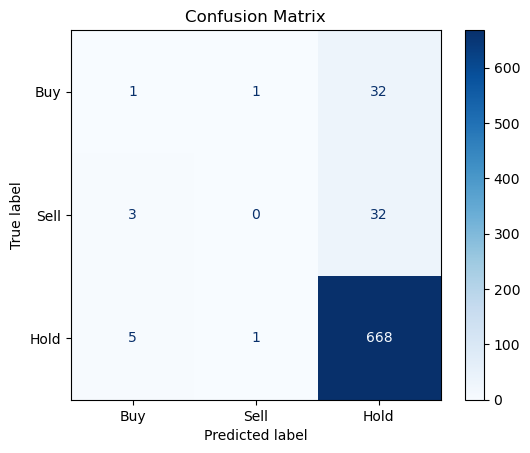

In [155]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
# cm = confusion_matrix(y_test, y_pred, labels=['Buy','Sell'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buy', 'Sell','Hold'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [162]:
import shap

def model_predict(data):
    return model.predict(data)

# Use a small sample of the data to initialize the KernelExplainer
background = X.sample(n=100, random_state=42)

# Initialize the SHAP KernelExplainer with the custom prediction function
explainer = shap.KernelExplainer(model_predict, background)

# Calculate SHAP values for a sample of the data
sample_data = X.sample(n=100, random_state=42)
shap_values = explainer.shap_values(sample_data)

# Plot the SHAP summary plot
%matplotlib inline
shap.summary_plot(shap_values, sample_data)

/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 35%|███▌      | 35/100 [01:06<02:06,  1.94s/it]

In [38]:
general_decision_df = pd.DataFrame(columns=[
            'Stock Name', 'Day', 'Action', 'Stock Price', 'Cash', 'Shares Held', 'Portfolio Value'])
general_decision_df.to_csv('data/specific_model_decisions.csv')
